In [1]:
from collections import OrderedDict
from imp import reload
import pdb
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import SVG, display

from hud_geo_conversions import read_zips_to_fips

from map_maker import draw_county_data_svg
from utilities import (display_cb, is_outlier_instance, is_outlier_val,
                       read_fips_codes)

from acs import ACSCountyReader, read_merge_acs
from religion_census import read_judaic_cngs
from jdata_counties import JDataCounties



pd.set_option('display.float_format', lambda x: '%.3f' % x)
from sklearn.decomposition import PCA

%matplotlib inline

SEED = 42
random.seed(SEED)

In [2]:
DATA_DIR    = '../Data/'
IMG_DIR = '../Images/'

DEM_DIR = ''.join([DATA_DIR, 'Demography/'])
SCL_DIR = ''.join([DATA_DIR, 'Schools/'])
REL_DIR  = ''.join([DATA_DIR, 'Religion/'])

ZIPS_TO_FIPS_FP = ''.join([DATA_DIR, 'ZIP_COUNTY_122016.xlsx'])
FIPS_TO_ZIPS_FP = ''.join([DATA_DIR, 'COUNTY_ZIP_122016.xlsx'])
FIPS_CODES_FP   = ''.join([DATA_DIR, 'Census-2010-County-FIPS.txt'])

# ACS data files
POP_FP           = ''.join([DEM_DIR, 'ACS_15_5YR_B01003/',
                            'ACS_15_5YR_B01003_with_ann.csv'])
FOREIGN_BIRTH_FP = ''.join([DEM_DIR, 'ACS_15_5YR_B05006/', 
                                'ACS_15_5YR_B05006_with_ann.csv'])
SNGL_ANCE_FP     = ''.join([DEM_DIR, 'ACS_15_5YR_B04004/',
                            'ACS_15_5YR_B04004_with_ann.csv'])
MULT_ANCE_FP     = ''.join([DEM_DIR, 'ACS_15_5YR_B04005/',
                           'ACS_15_5YR_B04005_with_ann.csv'])
ALL_ANCE_FP      = ''.join([DEM_DIR, 'ACS_15_5YR_B04006/',
                            'ACS_15_5YR_B04006_with_ann.csv'])

# US Religion Census data files
RELCEN_CB_FP  = ''.join([REL_DIR, 'US-Religion-Census-2010-County-File-CB.TXT'])
RELCEN_FP = ''.join([REL_DIR, 'US-Religion-Census-2010-County-File.DTA'])

# JData.org data file
JDATA_FP = ''.join([SCL_DIR, 'jdata_directory.json'])

# zip_to_fips =  read_zips_to_fips(ZIPS_TO_FIPS_FP)
# fips_codes = read_fips_codes(FIPS_CODES_FP)

## Merge Tables

Choosing to use counties instead of zips because zips are more likely to conflate same areas

Scaling methodology

- Try LDA, Factor Analysis

In [3]:
jdc = JDataCounties(JDATA_FP, ZIPS_TO_FIPS_FP)

jd_fips = jdc.get_county_cnts(excl_org_types=['Day camp', 'Overnight camp'])

In [4]:
jd_fips.T

FIPS,01045,01069,01073,01081,01087,01089,01097,01101,02020,02090,...,55025,55059,55063,55073,55079,55087,55089,55133,55139,56001
Type_Day_school,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
Type_Early_childhood_center,0.000,0.000,3.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,...,2.000,0.000,0.000,0.000,3.000,0.000,1.000,0.000,0.000,0.000
Type_Part_time_school,0.080,0.920,3.000,0.987,0.013,1.000,2.000,1.000,2.000,1.000,...,4.000,1.000,1.000,1.000,5.000,1.000,3.000,1.000,1.000,1.000
Denom_Conservative,0.000,0.000,1.167,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,1.400,0.000,1.000,0.000,1.083,1.000,1.333,0.000,0.000,0.000
Denom_Nondenom,0.000,0.000,2.333,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,4.200,0.000,0.000,0.000,2.167,0.000,0.000,0.000,0.000,0.000
Denom_Orthodox,0.000,0.000,2.333,0.000,0.000,0.000,0.000,0.000,1.333,0.000,...,0.000,0.000,0.000,0.000,6.500,0.000,1.333,0.000,0.000,0.000
Denom_Reconstructionist,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,1.333,0.000,0.000,0.000
Denom_Reform,0.080,0.920,1.167,0.987,0.013,1.000,1.000,0.000,2.667,1.000,...,1.400,1.000,0.000,1.000,3.250,0.000,0.000,1.000,1.000,1.000


In [5]:
params = [
    dict(name='Born_Isr', kw='Israel', fp=FOREIGN_BIRTH_FP),
    dict(name='Ance_Isr', kw='Israeli', fp=ALL_ANCE_FP),
    ]
    
acs = read_merge_acs(params)

In [6]:
from imp import reload
import religion_census
reload(religion_census)
from religion_census import read_judaic_cngs
relcen = read_judaic_cngs(RELCEN_FP, standard_cols=False)

In [54]:
counties = pd.concat([jd_fips, relcen], axis=1).fillna(0).drop(['ReconJud_Cngs', 'UnionMessJews_Cngs'], axis=1)

In [55]:
counties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 619 entries, 01015 to 56001
Data columns (total 11 columns):
Type_Day_school                619 non-null float64
Type_Early_childhood_center    619 non-null float64
Type_Part_time_school          619 non-null float64
Denom_Conservative             619 non-null float64
Denom_Nondenom                 619 non-null float64
Denom_Orthodox                 619 non-null float64
Denom_Reconstructionist        619 non-null float64
Denom_Reform                   619 non-null float64
ConsvJud_Cngs                  619 non-null float64
OrthJud_Cngs                   619 non-null float64
RefJud_Cngs                    619 non-null float64
dtypes: float64(11)
memory usage: 58.0+ KB


In [56]:
print('Fraction of counties with count data')
((counties>0).sum()/len(counties)).sort_values()

Fraction of counties with count data


Denom_Reconstructionist       0.118
Type_Day_school               0.262
Denom_Orthodox                0.302
Denom_Nondenom                0.333
Type_Early_childhood_center   0.339
Denom_Conservative            0.352
OrthJud_Cngs                  0.375
ConsvJud_Cngs                 0.393
Denom_Reform                  0.645
RefJud_Cngs                   0.771
Type_Part_time_school         0.782
dtype: float64

In [57]:
# counties = counties.drop('Type_Early_childhood_center', axis=1)

In [58]:
counties[counties.sum(1)==1].head()

,Type_Day_school,Type_Early_childhood_center,Type_Part_time_school,Denom_Conservative,Denom_Nondenom,Denom_Orthodox,Denom_Reconstructionist,Denom_Reform,ConsvJud_Cngs,OrthJud_Cngs,RefJud_Cngs
01015,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
01047,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
01125,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
02122,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
04003,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


In [59]:
from sklearn_pandas import DataFrameMapper

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

class LogStandardScaler(StandardScaler):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def fit(self, X, y=None):
        return super().fit(np.log(X+1))
    
    def transform(self, X, y=None):
        return super().transform(np.log(X+1))

reducer = Pipeline([
    ('scaler', LogStandardScaler()),
    ('reducer', PCA())
])


In [60]:
cnty_scl = pd.DataFrame(
    LogStandardScaler().fit_transform(counties),
    index=counties.index, columns=counties.columns)

In [61]:
cnty_scl.describe()

,Type_Day_school,Type_Early_childhood_center,Type_Part_time_school,Denom_Conservative,Denom_Nondenom,Denom_Orthodox,Denom_Reconstructionist,Denom_Reform,ConsvJud_Cngs,OrthJud_Cngs,RefJud_Cngs
count,619.000,619.000,619.000,619.000,619.000,619.000,619.000,619.000,619.000,619.000,619.000
mean,0.000,-0.000,0.000,0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,-0.000
std,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001,1.001
min,-0.457,-0.551,-1.059,-0.589,-0.577,-0.507,-0.326,-0.890,-0.662,-0.576,-1.291
25%,-0.457,-0.551,-1.026,-0.589,-0.577,-0.507,-0.326,-0.890,-0.662,-0.576,0.025
50%,-0.457,-0.551,-0.242,-0.589,-0.577,-0.507,-0.326,0.093,-0.662,-0.576,0.025
75%,-0.409,0.330,0.539,0.386,0.498,0.338,-0.326,0.129,0.483,0.196,0.025
max,7.019,4.902,4.382,4.832,4.642,6.061,6.471,4.768,4.897,5.870,4.967


In [62]:
reducer = PCA(n_components=len(cnty_scl.T))
reducer.fit(cnty_scl)
reducer.explained_variance_ratio_.tolist()

[0.7671742708370388,
 0.06487344219076326,
 0.04971060096817904,
 0.03409818776389573,
 0.027538645027057752,
 0.020408373501318546,
 0.011149202711179971,
 0.008808362681829208,
 0.008121107712837498,
 0.006799608583274425,
 0.0013181980226256225]

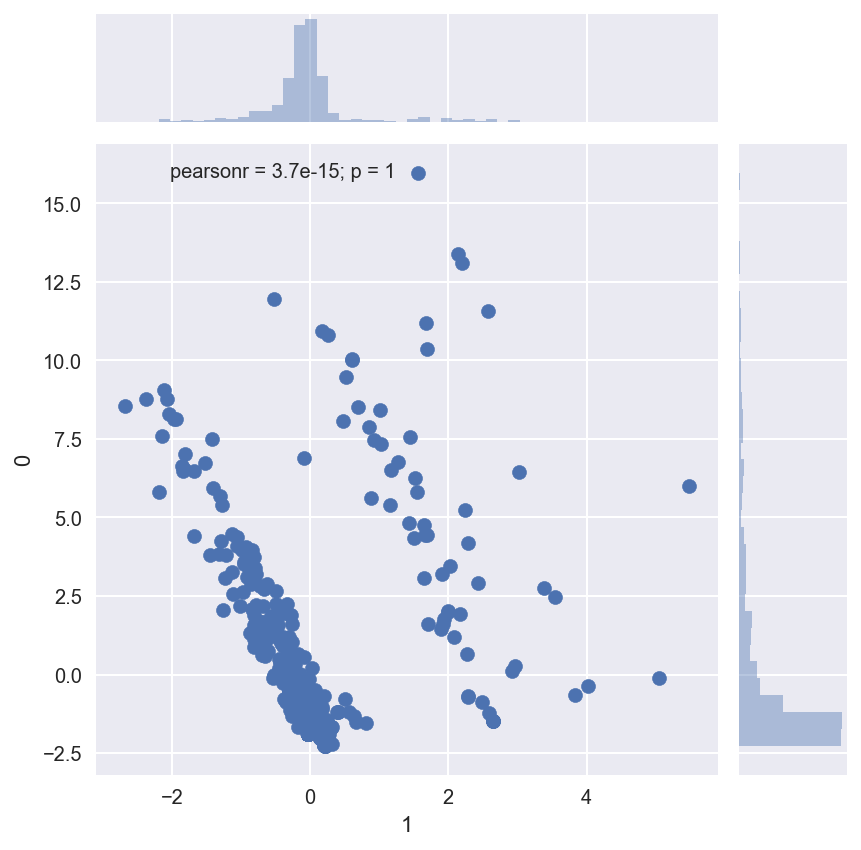

In [63]:
reduced = reducer.transform(cnty_scl)
reduced = pd.DataFrame(reduced)
sns.jointplot(x=1, y=0, data=reduced)

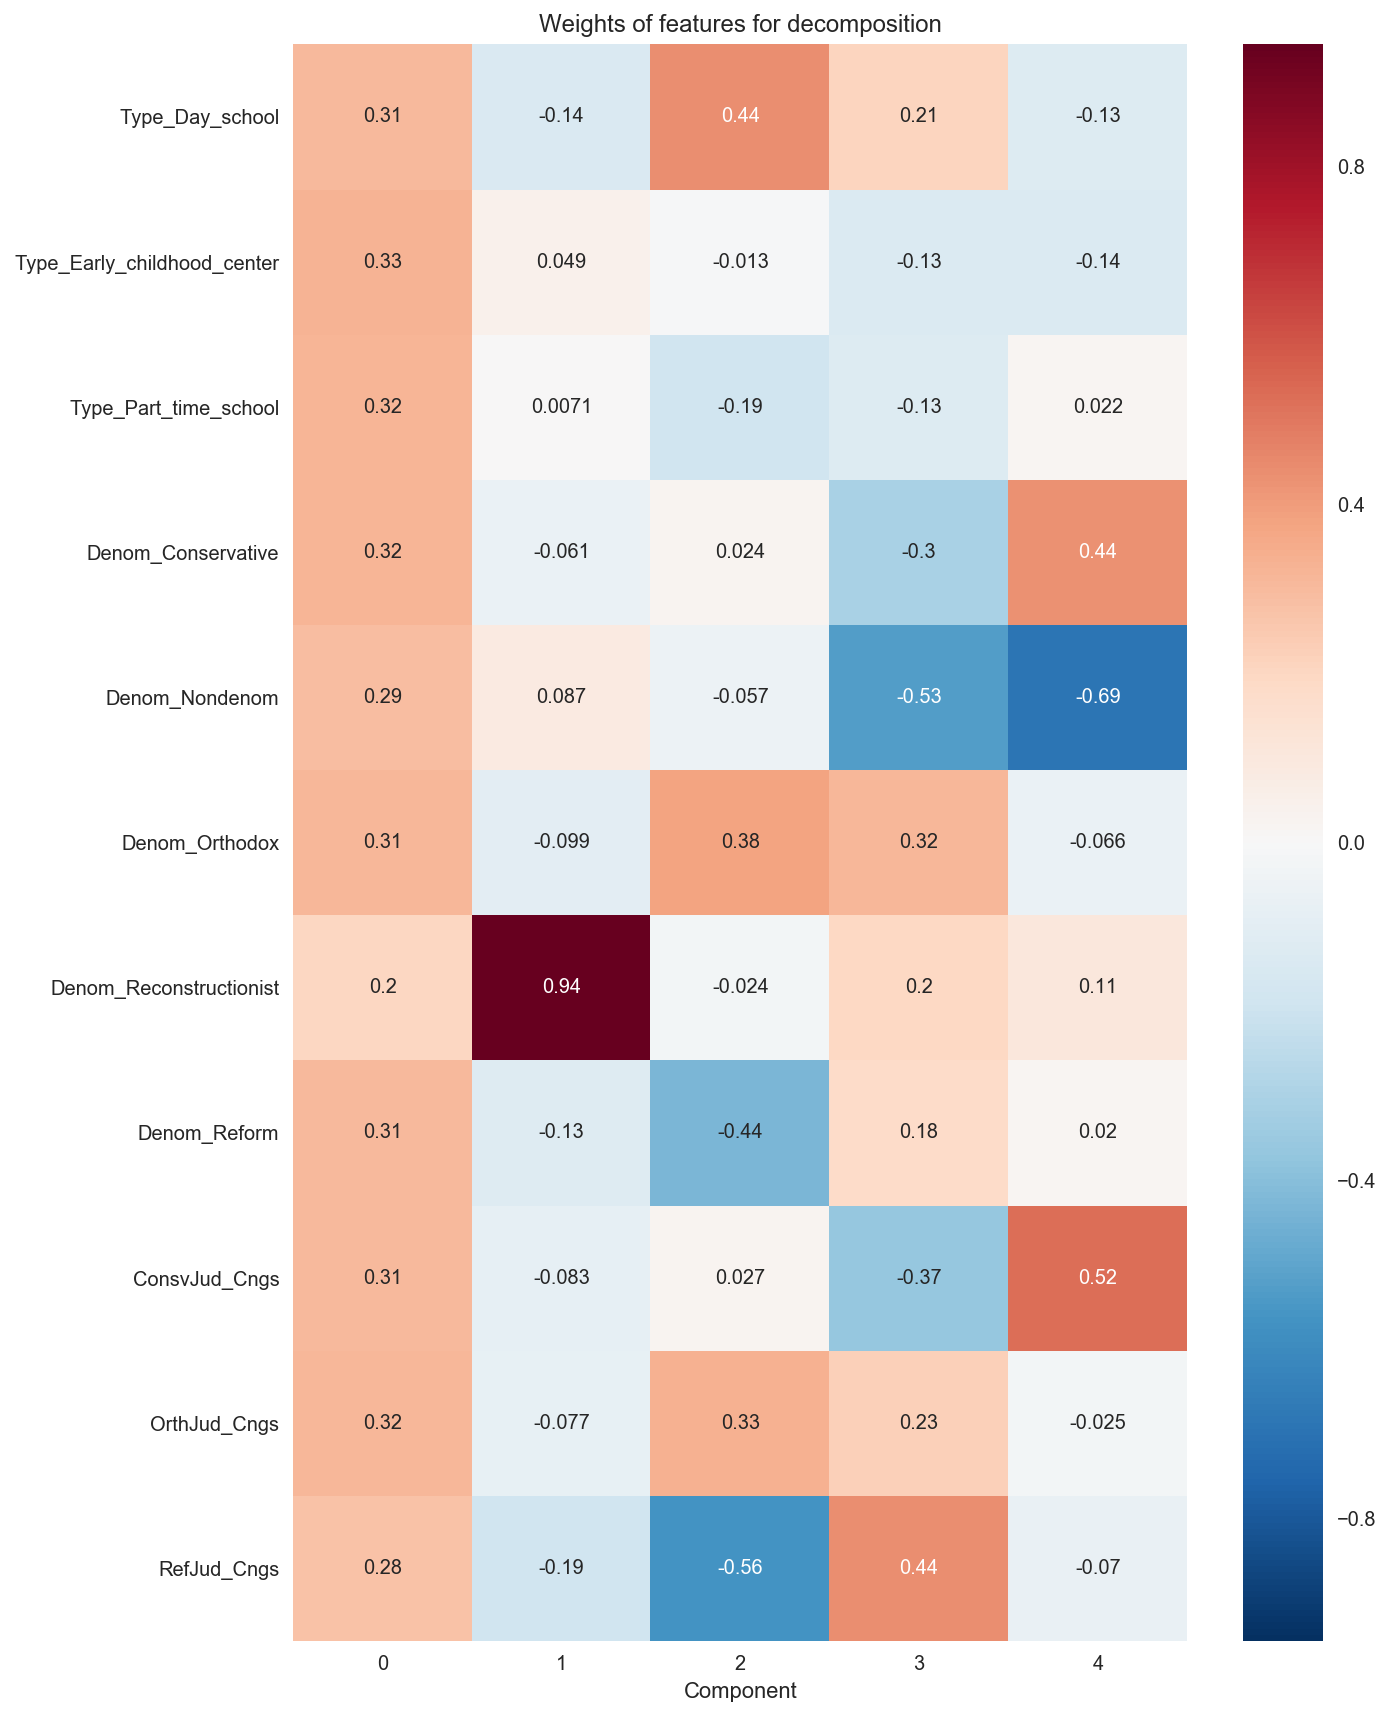

In [64]:
comps = pd.DataFrame(reducer.components_[:5, :], columns=cnty_scl.columns)
plt.figure(figsize=(10, 12))
sns.heatmap(comps.T, annot=True)

plt.title('Weights of features for decomposition')
plt.xlabel('Component')

plt.tight_layout();

In [65]:
import hdbscan

In [66]:
clust = hdbscan.HDBSCAN(min_cluster_size=5).fit(cnty_scl)

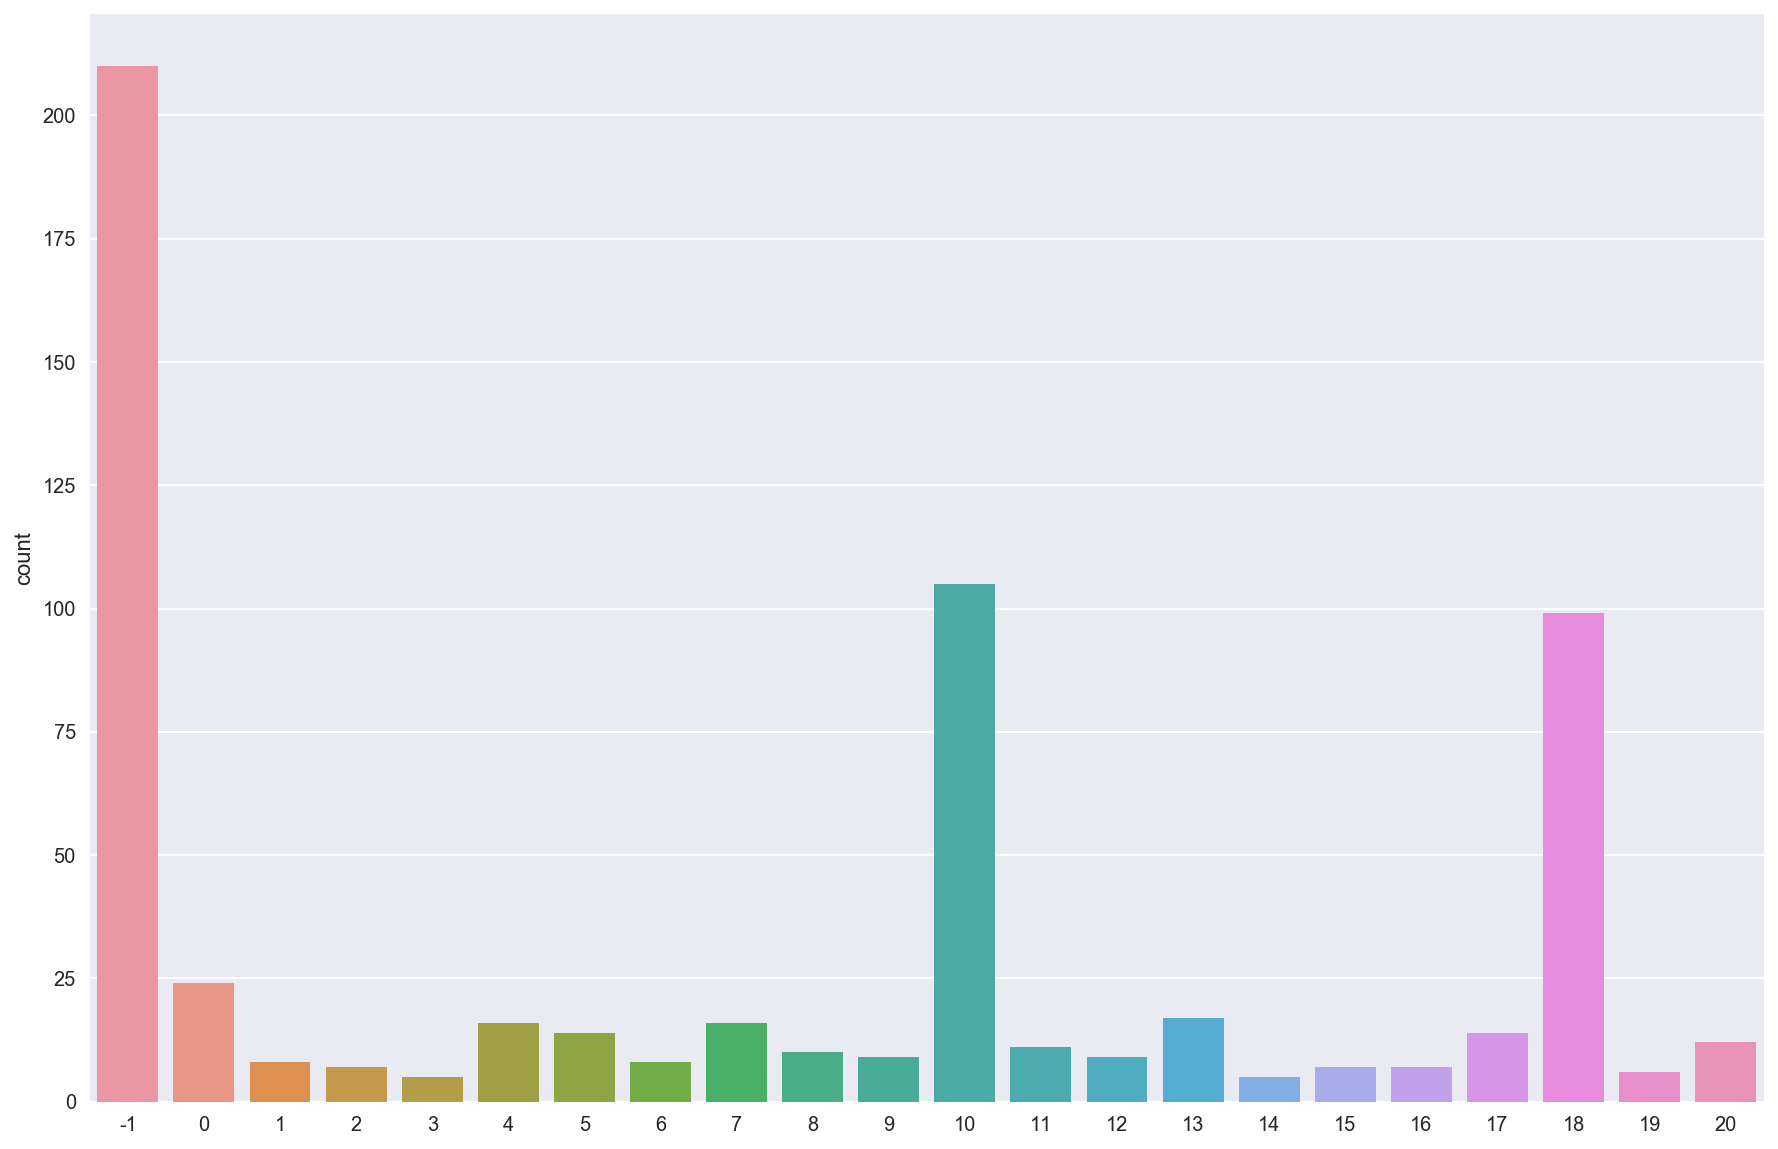

In [67]:
plt.figure(figsize=(15, 10))
sns.countplot(clust.labels_)


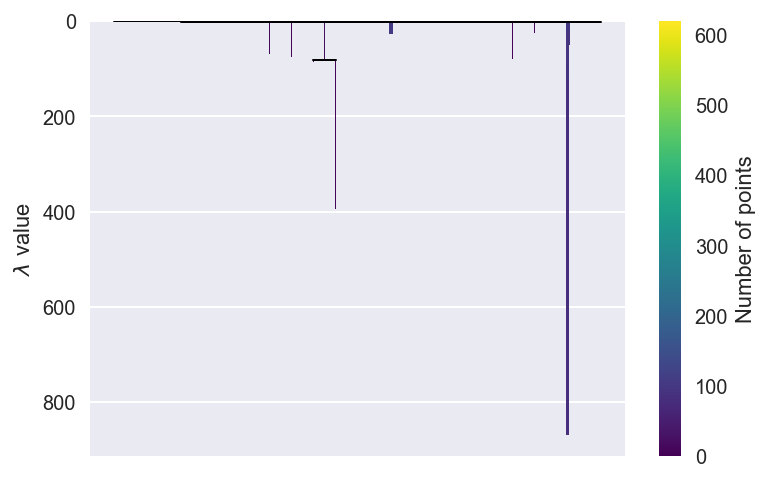

In [68]:
clust.condensed_tree_.plot(log_size=False, label_clusters=True)
# plt.ylim(300, 0)

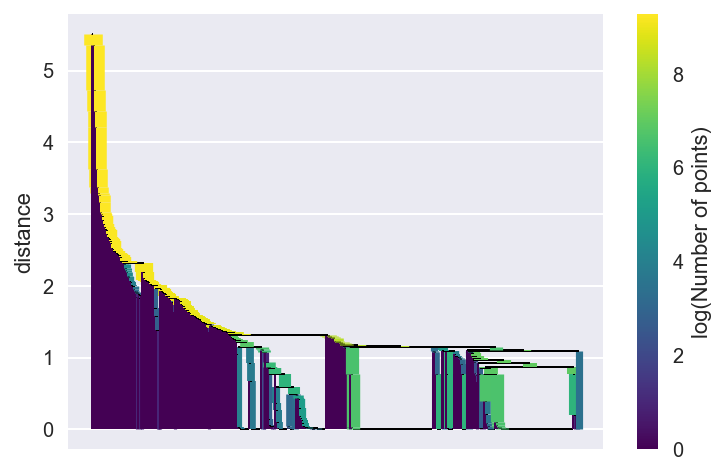

In [69]:
clust.single_linkage_tree_.plot()

In [70]:
df = clust.single_linkage_tree_.to_pandas()
df.head()

,parent,left_child,right_child,distance,size
0,619,0.000,393.000,0.000,2.000
1,620,488.000,427.000,0.000,2.000
2,621,489.000,464.000,0.000,2.000
3,622,227.000,621.000,0.000,3.000
4,623,494.000,620.000,0.000,3.000


In [71]:
data.cluster.unique()

AttributeError: 'DataFrame' object has no attribute 'cluster'

In [72]:
data = pd.DataFrame(reducer.transform(cnty_scl)).assign(cluster=clust.labels_)
data.cluster.unique()

array([10, -1, 18, 19, 12, 13, 11, 17,  2,  8,  1, 16,  0,  3,  5,  4, 15,
        7, 14, 20,  6,  9])

In [73]:
x = sorted(((x, i) for i, x in enumerate(np.bincount(clust.labels_+1))), reverse=True)[:]
clust_n = [n for _, n in x]

KeyboardInterrupt: 

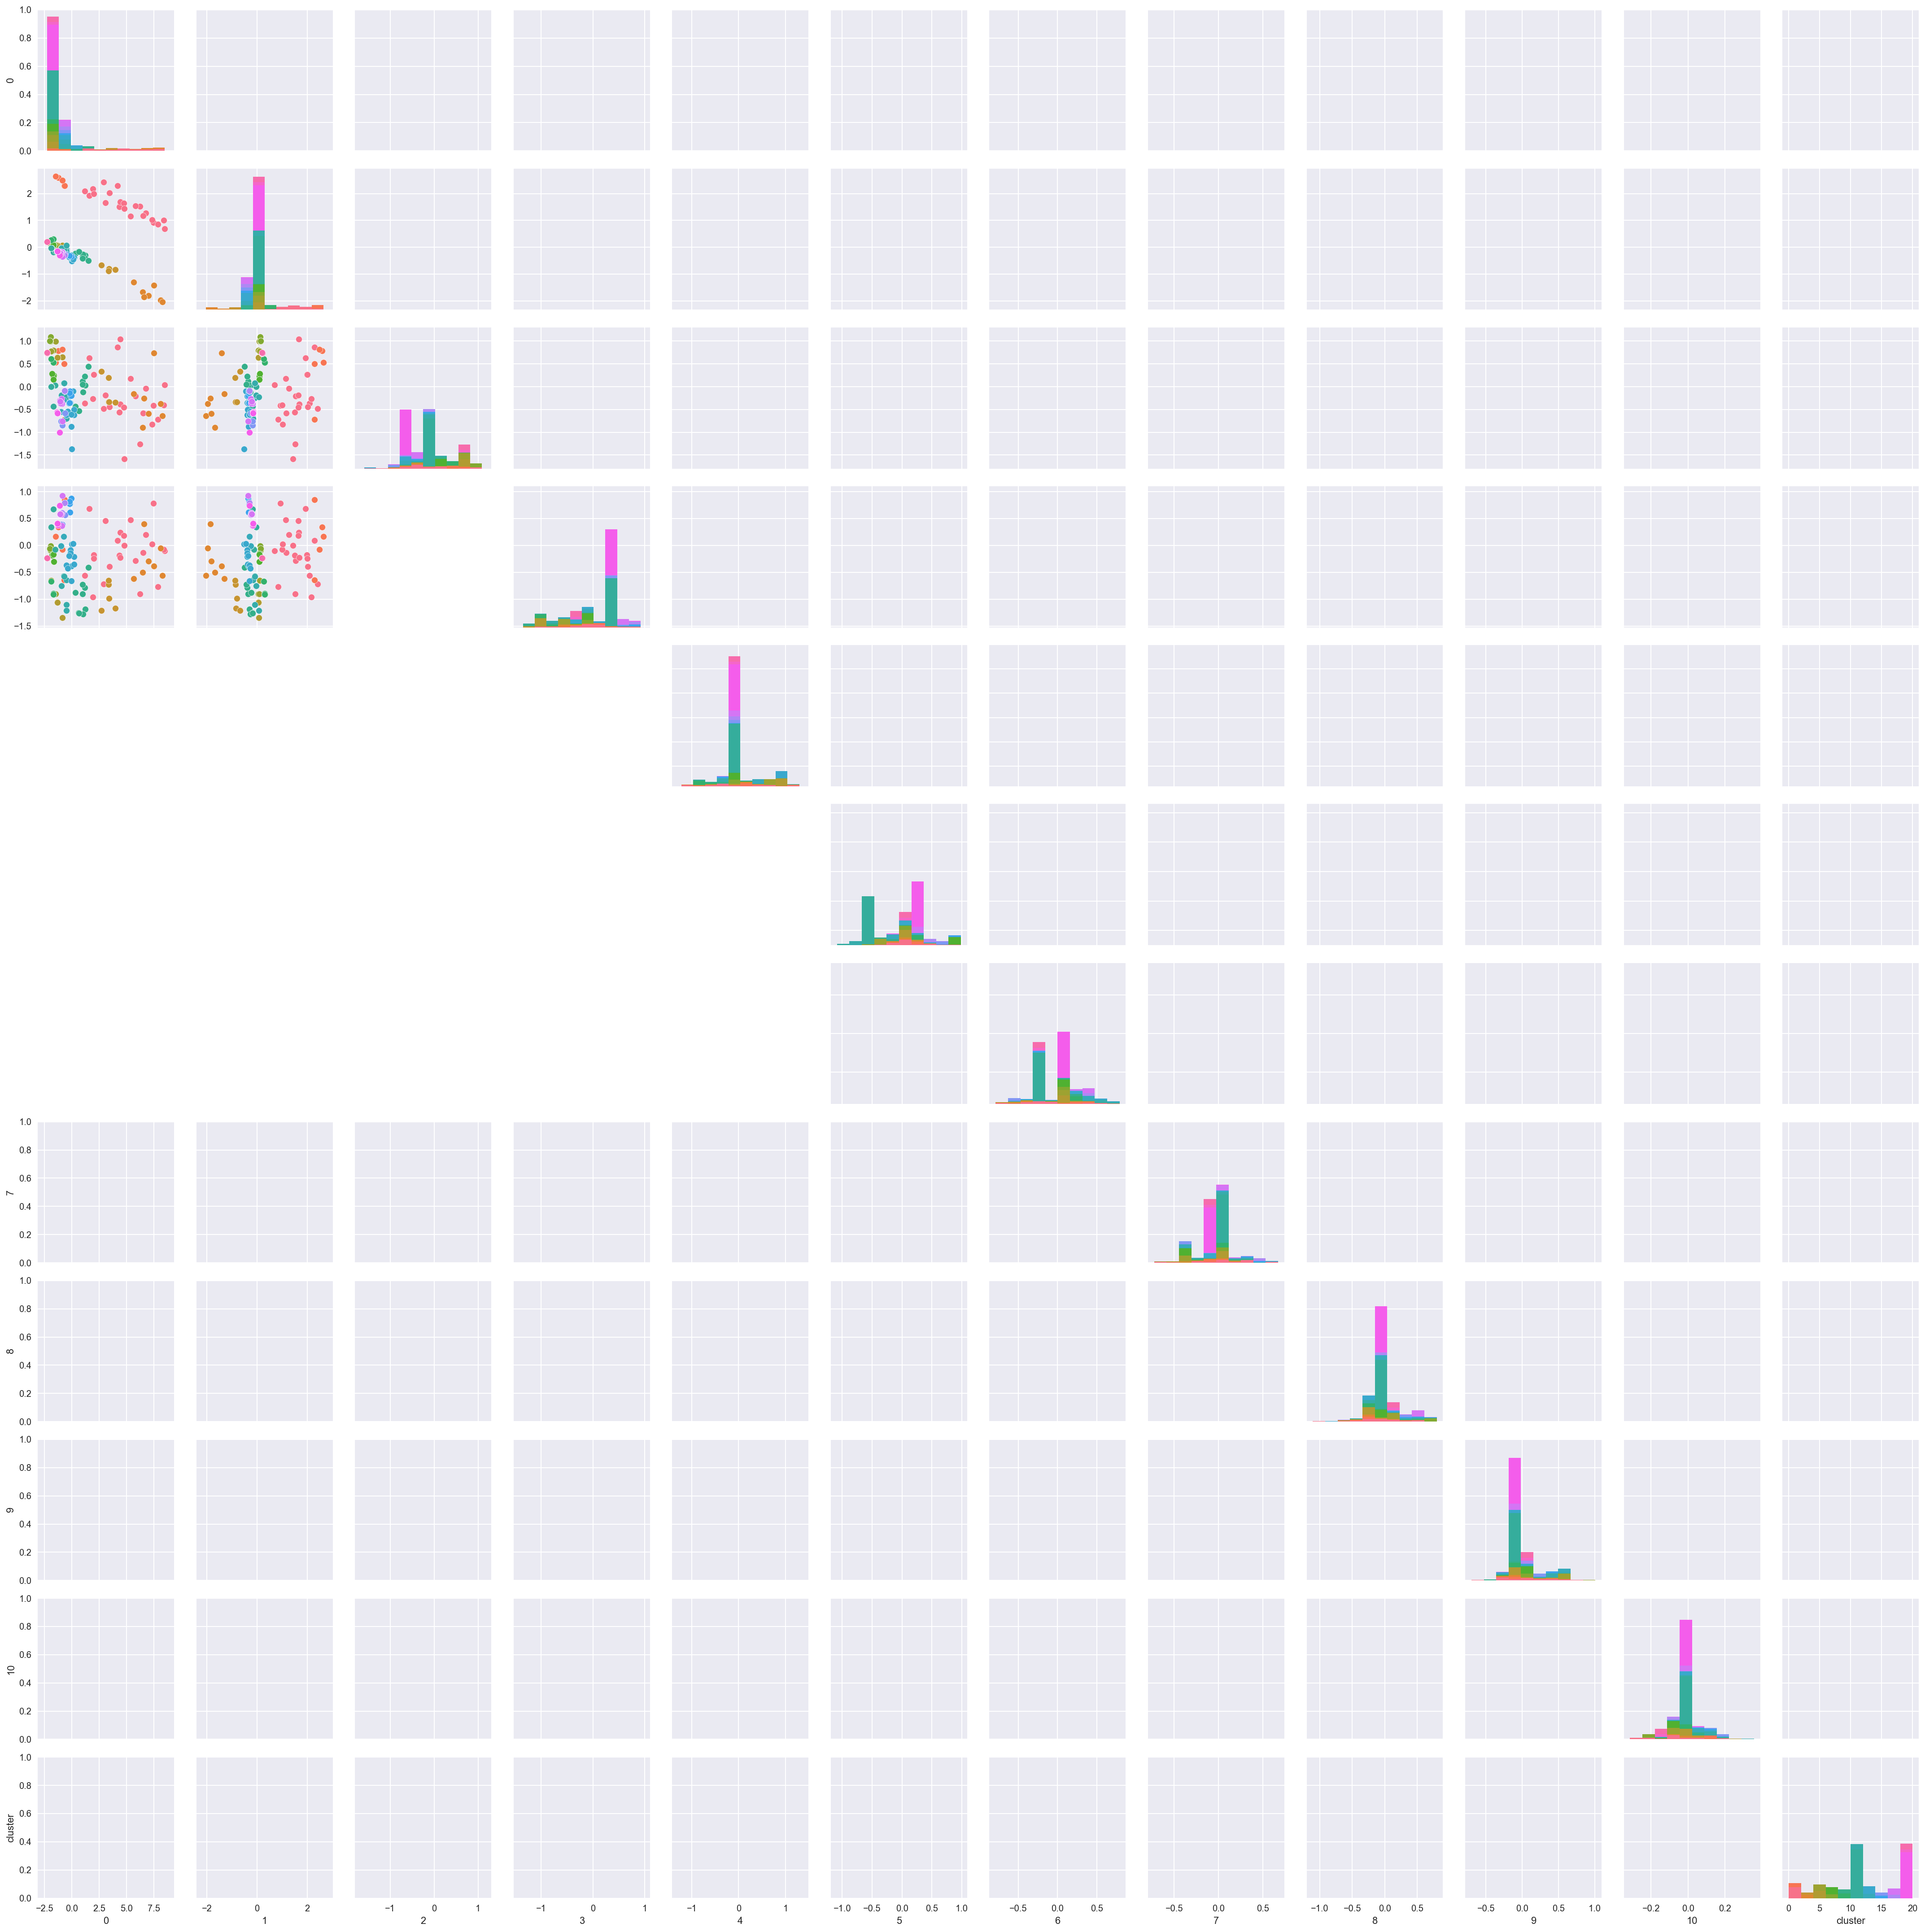

In [74]:
plt.figure(figsize=(5, 5))

sns.pairplot(data=data[data.cluster.isin(clust_n)], hue='cluster', )
plt.tight_layout()

In [75]:
data = cnty_scl.assign(cluster=clust.labels_)

In [76]:
data = pd.melt(data, id_vars='cluster')

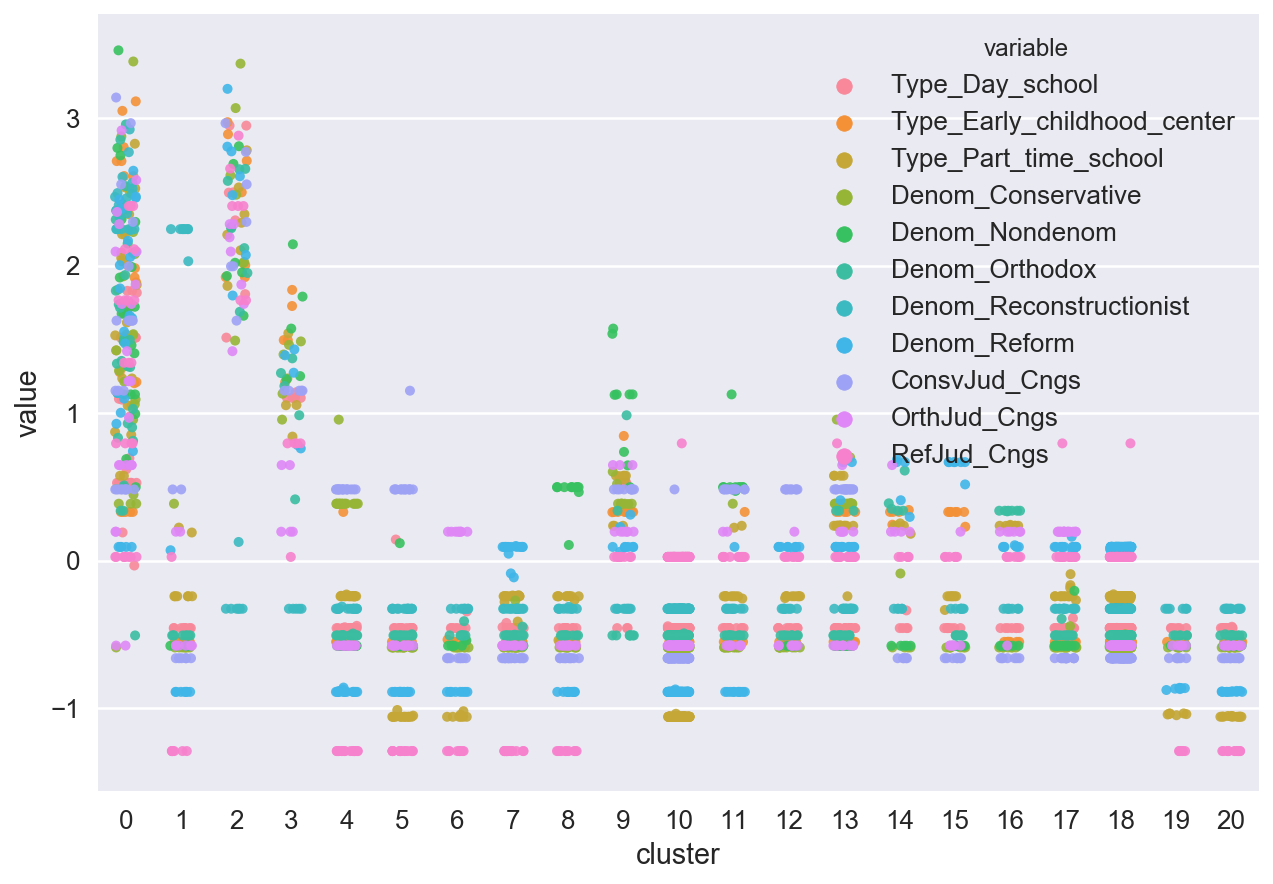

In [77]:
with sns.plotting_context('talk'):
    sns.stripplot(data=data[data.cluster>-1], x='cluster', hue='variable', y='value',
                  jitter=.2, alpha=.9)

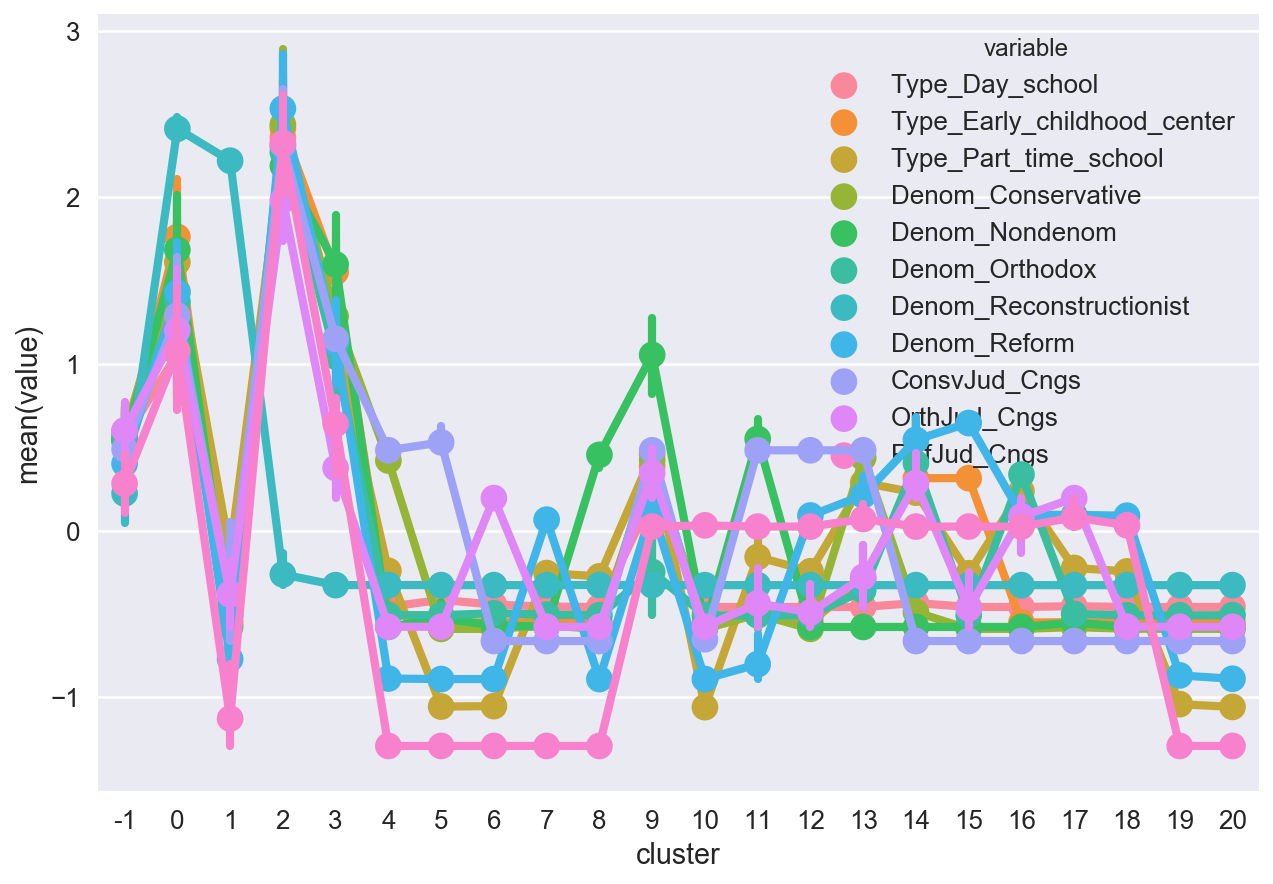

In [78]:
with sns.plotting_context('talk'):
    sns.pointplot(data=data[data.cluster>-2], x='cluster', hue='variable', y='value',)

In [79]:
reduced = reducer.transform(cnty_scl)
reduced = pd.DataFrame(reduced)
data= pd.concat([reduced, pd.DataFrame(clust.labels_, columns=['Label'])], axis=1).head()

AttributeError: Unknown property hue

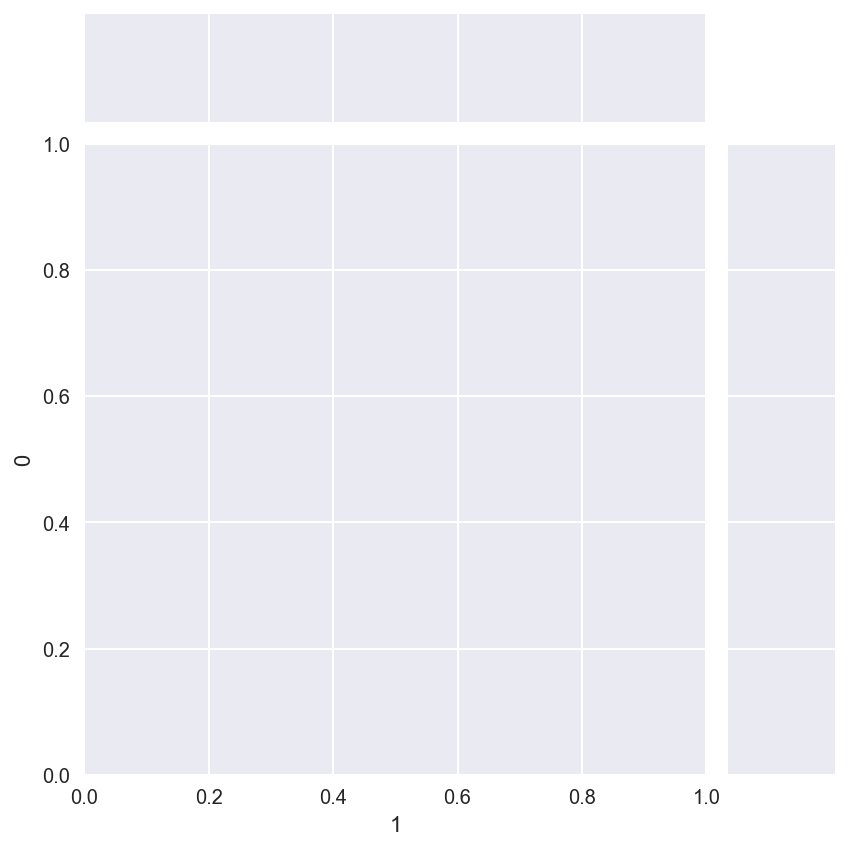

In [53]:
sns.jointplot(x=1, y=0, data=data, hue='Label')

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

for i in range(5, 10):
    clust = KMeans(20).fit(cnty_scl)
    score = silhouette_score(cnty_scl, clust.predict(cnty_scl))
    print(score)

# data = cnty[clust.labels_>-1]
# preds = clust.labels_[clust.labels_>-1]
# silhouette_score(data, preds)

In [ ]:
DIR = ''.join([IMG_DIR, 'play'])
colors = list(sns.color_palette('husl', len(np.unique(clust.labels_))).as_hex())
draw_county_data_svg(pd.Series(clust.labels_+1, index=cnty.index, name='clust'), DIR,
                     colors=colors, zero_color='#bebebe')

SVG(DIR)

In [ ]:
data = cnty.assign(cluster=clust.labels_)
sns.pointplot(x='cluster', y='Denom_Reform', data=data)

In [ ]:
ajpp_county = read_ajpp_county(AJPP_FP, AJPP_GEO_FP)

In [ ]:
data = (pd.DataFrame(clust.labels_, index=cnty.index, columns=['clust'])
        .join(ajpp_county))

sns.boxplot(x='clust', y='Jewish_By_Rel', data=data)
plt.semilogy();

In [ ]:
data = (pd.DataFrame(clust.labels_, index=cnty.index, columns=['clust'])
        .join(urb_rur))

sns.boxplot(x='clust', y='POPPCT_URBAN', data=data)

In [ ]:
data.groupby('pred').mean()

In [ ]:
data = cnty.assign(cluster=clust.labels_).groupby('cluster').count()
data

In [ ]:
data = (data
        .assign(cluster=clust.labels_).groupby('cluster').mean())
sns.heatmap(data=data)
plt.title('Compare Means of MinMaxScaled features.')

In [ ]:
data = (pd.DataFrame(MinMaxScaler().fit_transform(cnty),
                     columns=cnty.columns)
        .assign(cluster=clust.labels_).groupby('cluster').mean())
sns.heatmap(data=data)
plt.title('Compare Means of MinMaxScaled features.')

In [ ]:
from yellowbrick.features.rankd import Rank2D
from yellowbrick.features.radviz import RadViz
from yellowbrick.features.pcoords import ParallelCoordinates


visualizer = Rank2D(algorithm='covariance')

visualizer.fit(cnty)                # Fit the data to the visualizer
visualizer.transform(cnty)             # Transform the data
visualizer.poof();    # Draw/show/poof the data

In [ ]:
visualizer = ParallelCoordinates()

visualizer.fit(cnty.as_matrix(), np.random.randint(0, 5, 662))     # Fit the data to the visualizer
visualizer.transform(cnty)   # Transform the data
visualizer.poof()    ;     # Draw/show/poof the data

In [ ]:
rc_drop = ['County', 'State',
           'Tot_Cngs', 'Tot_No', 'Tot_Pc']

merged = (acs.join(urb_rur[['POPPCT_URBAN']])
          .join(jd_county, how='outer')
          .join(relcen.drop(rc_drop, axis=1), how='outer')
          .fillna(0))

In [ ]:
# dropping rows that are needed to be empty at first, i.e.
# drop_counties=False (default) for read_acs, because
# general population data is used for counties with only
# jdata org data
has_dat = (merged.loc[:, 'Only_Israeli_No':]!=0.).any(1)
merged = merged[has_dat]
merged.T.head()

In [ ]:
merged.shape, acs.shape, jd_county.shape, relcen.shape

In [ ]:
merged[stdrd_cols+cols].shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler
x = merged[['Tot_Jews', 'Tot_JewCngs']]
scaled = pd.DataFrame(MinMaxScaler().fit_transform(x),
                      columns=['Tot_Jews_Sc', 'Tot_JewCngs_Sc'],
                      index=x.index)
x = pd.concat([x, scaled], axis=1)
# sns.pairplot(x, 

In [ ]:
stdrd_cols = ['Total_Pop']

cols = [
    'Only_Israeli_No',
    'Part_Israeli_No',
    'Tot_Israeli_No',
    'POPPCT_URBAN',
    
    'Denom_Conservative',
    'Denom_Orthodox',
    'Denom_Other',
    'Denom_Reconstructionist',
    'Denom_Reform',
    'Tot_Orgs',
    'ConsvJud_No',
    'OrthJud_No',
    'ReconJud_No',
    'RefJud_No',
    'UnionMessJews_Cngs',
    'Tot_Jews',
    'Tot_JewCngs',
    'Type_Day_school',
    'Type_Early_childhood_center',
    'Type_Part_time_school',]

sns.pairplot(merged[stdrd_cols+cols])

## Exploration

More info on SVGs:
http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/IPython%20Kernel/Rich%20Output.ipynb
http://flowingdata.com/2009/11/12/how-to-make-a-us-county-thematic-map-using-free-tools/
https://github.com/jaeahlee/svg-map-counties.git

In [ ]:
dat_no = merged.select(lambda x: not x.endswith('_Pc'), axis=1)
dat_tots = merged.select(lambda x: x.startswith('Tot') or x in ['County', 'State'], axis=1)
dat_tots = merged.select(lambda x: x.startswith('Tot_') and not x.endswith('_Pc'), axis=1)
dat_tots.head()

In [ ]:
has_relcen = (dat_tots.Tot_JewCngs!=0) | (dat_tots.Tot_Jews!=0)
has_acs = dat_tots.Tot_Israeli_No!=0
has_jdata = dat_tots.Tot_Orgs!=0

mer_has_dat = pd.DataFrame(dict(Congregants=has_relcen,
                                Israeli=has_acs,
                                Orgs=has_jdata))
n_sources= mer_has_dat.sum(1)

How much data do we have on counties?

In [ ]:
import map_maker
reload(map_maker)
from map_maker import draw_county_data_svg

DIR = ''.join([IMG_DIR, 'num_data_sources.svg'])

# Map colors
data = n_sources
bins = [1, 2, 3]

svg = draw_county_data_svg(data, DIR, bins=bins)

SVG(DIR)

In [ ]:
ax = sns.boxplot(x='Sources', y='Total_Pop', 
                 data=merged.join(n_sources.to_frame(name='Sources')))
ax.set_title('County population by number of data sources')
ax.set_yscale('log')
sns.despine()

In [ ]:
# fraction of counties with n data points
n_sources.value_counts(normalize=False).to_frame().T

In [ ]:
mer_has_dat[n_sources==1].sum()

In [ ]:
mer_has_dat.sum()

In [ ]:
plt.hist

In [ ]:
fig, ax = plt.subplots()
legend = []
for i in range(1, 4):
    sns.distplot(merged[n_sources==i].POPPCT_URBAN, bins=100, kde=False,
                 hist_kws=dict(cumulative=True, label=str(i)), ax=ax)
    legend.append(str(i))
plt.legend(legend)

In [ ]:
merged[(dat_tots==0).sum(1)==3]

In [ ]:
from ajpp import read_ajpp_geo
ajpp_geo = read_ajpp_geo(AJPP_GEO_FP)
ajpp_geo.Region.to_frame().join(merged[n_sources==1], how='inner').head()

In [ ]:
merged[n_sources==1].sort_values('Tot_Orgs', ascending=False).loc[:, :'Tot_Orgs']

In [ ]:
import map_maker
reload(map_maker)
from map_maker import draw_county_data_svg

DIR = ''.join([IMG_DIR, 'num_data_exploring.svg'])

data = merged[n_sources==1].Tot_Orgs
bins = [1, 2, 3, 4]
color_pal = sns.color_palette('Reds', n_colors=len(bins))
sns.palplot(color_pal)
colors = color_pal.as_hex()

svg = draw_county_data_svg(data, DIR, colors, bins)

SVG(DIR)

In [ ]:
x = dat_no.columns[10:22]
y = dat_no.columns[[24, 26, 28, 30]]
dat = dat_no
sns.pairplot(x_vars=x, y_vars=y, data=dat)

In [ ]:
dat_no.assign(j_pc=dat_no.Tot_Jews/dat_no.Total_Pop).sort_values('j_pc', ascending=False)
dat_no.sort_values('Total_Pop', ascending=False)
sum(dat_no.Total_Pop<1000000)

In [ ]:
dat_no.Total_Pop.describe()

In [ ]:
plt.hist(dat_no.Total_Pop, cumulative=True, bins=1000, normed=True);

In [ ]:
ProbPlots(dat_no.Total_Pop).plot_probplot('lognorm')

In [ ]:
def plot_n_nonzeros(df):
    plt.hist((df!=0).sum(1), cumulative=True, normed=True, bins=1000, align='mid')
# plot_n_nonzeros(dat_no.iloc[:, 2:])
# plot_n_nonzeros(dat_tots)

In [ ]:
plt.hist(dat_tots.Tot_Jews, cumulative=True, bins=1000, normed=True);

In [ ]:



dat_tots[~is_outlier_instance(dat_tots.Tot_JewCngs)].shape

In [ ]:
sum(dat_tots.Tot_Jews==0)

In [ ]:
plot_dists_pps(pd.DataFrame(zscore(dat_tots.values)), 'norm')

In [ ]:
plot_dists_pps(dat_tots.apply(lambda x: np.log(x+1)), 'norm')

In [ ]:
fips_list = idx
bools = []
for fips in fips_list:
    zips = zip_to_cnty[zip_to_cnty.COUNTY==fips].ZIP.tolist()
    bools.append(jd_df.Zip.isin(zips))

jdata[pd.concat(bools, axis=1).any(1)]

In [ ]:
idx = dat_tots[
    (dat_tots[['Tot_Israeli_No', 'Tot_Israeli_Pc', 'Tot_Jews', 'Tot_JewCngs']]==0)
    .all(1)].index

In [ ]:
dat_tots.sort_values(['Tot_Jews', 'Tot_Israeli_No'], ascending=True).iloc[0:]

In [ ]:
# sns.pairplot(np.log(dat_tots+1))
data = dat_tots[~is_outlier_instance(dat_tots.Tot_JewCngs)]
data = dat_tots
sns.pairplot(data)

In [ ]:

from sklearn.decomposition import PCA

In [ ]:
scaled = boxcox_standardize(data)

pca = PCA(n_components=None, random_state=SEED)
pca.fit(scaled)
pca_d = pca.transform(scaled)


In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
sum(pca.explained_variance_ratio_[:10])

In [ ]:
pca_d[:][:]

In [ ]:
dat = pca_d[:][:15]
dat

In [ ]:
from collections import namedtuple
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


DIMS = 15

MIN_CLUSTERS = 2  # min must be >= 2
MAX_CLUSTERS = DIMS  # ?? why limit on this

scores = []
dat = pd.DataFrame(pca_d[:][:DIMS]).rename(columns=lambda x: ' '.join(['Dimension', str(x)]))
dat = dat_tots.apply(lambda x: zscore(np.log(x+1)))

idx = [random.randint(0, dat.shape[0]-1), random.randint(0, dat.shape[0]-1), random.randint(0, dat.shape[0]-1)]
samples = pca_d[idx]

for n in range(MIN_CLUSTERS, MAX_CLUSTERS+1):
    # TODO: Apply your clustering algorithm of choice to the reduced data   
    clusterer = KMeans(n_clusters=n, random_state=SEED)
    clusterer.fit(dat)

    # TODO: Predict the cluster for each data point
    preds = clusterer.predict(dat)

    # TODO: Find the cluster centers
    centers = clusterer.cluster_centers_

    # TODO: Predict the cluster for each transformed sample data point
#     sample_preds = clusterer.predict(samples)

    # TODO: Calculate the mean silhouette coefficient for 
    # the number of clusters chosen
    score = silhouette_score(dat, preds)
    scores.append((n, score))


scores

In [ ]:
# Fit the clusterer with optimal n_clusters param
scores.sort(reverse=True, key=lambda elem: elem[1])
best_n_clust = scores[0][0]

clusterer = KMeans(n_clusters=best_n_clust, random_state=SEED)
clusterer.fit(dat)

preds = clusterer.predict(dat)
# sample_preds = clusterer.predict(reduced_samples_2d)

centers = clusterer.cluster_centers_
score = silhouette_score(dat, preds)

print(score)

In [ ]:
data = pd.concat([dat_tots.reset_index(drop=True), pd.DataFrame(preds, columns=['preds'])], axis=1)
x = 'preds'
sns.boxplot(x=x, y='Tot_Israeli_No', data=data)

In [ ]:
sns.pairplot(data[merged.preds!=1], hue='preds')

In [ ]:
g = merged.groupby('preds')
g.describe()